In [23]:
# Discrimeter MI estimator (MIT)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [24]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--gamma", type=float, default=1e-5, help="clip the ratio")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=40000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
# parser.add_argument("--latent_dim", type=int, default=1, help="dimensionality of the latent space")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--alpha", type=float, default=0.99, help="RMSprop: smoothing constant ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
# parser.add_argument("--confidence", type=float, default=0.005, help="smooth parameter")

# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

In [25]:
# construct the data
rep = 1
density = 'Gaussian'
# use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

def generate_data(distribution='Gaussian', rho=0.9):
    # np.random.seed(seed)
    # # initialize random seed
    # torch.manual_seed(seed)
    mu1 = 0
    mu2 = 0

    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))
    # print('start generating')
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size,mean1=mu1, mean2=mu2,rho1=rho,rho2=-rho)
    # print('end generate')
    mi = mg.ground_truth * opt.d
    data = mg.data
    for j in range(opt.d):
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)
    return XY, X, Y, mi

In [26]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        # output = F.sigmoid(self.fc3(output))
        output = self.fc3(output)
        return output

In [27]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# loss
categorical_loss = torch.nn.CrossEntropyLoss()
adversarial_loss = torch.nn.BCELoss()
bcelogit_loss = nn.BCEWithLogitsLoss()

if cuda:
    discriminator.cuda()
    adversarial_loss.cuda()
# Optimizers Adam
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

def smooth_ce_loss(pre_label, true_label, smoothing, num_classes):
    new_labels = (1.0 - smoothing) * true_label + smoothing / num_classes
    return adversarial_loss(pred_label, new_labels)

def infonce_loss(net, x_samples, y_samples):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))  #[sample_size, sample_size, 1]

    lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size)) 
    return lower_bound

In [28]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
mi_list = []
acc_list = []
for i in range(opt.n_iters):
    data_joint = _resample(XY, batch_size=opt.batch_size)
    x_samples = data_joint[:,0:opt.d]
    y_samples = data_joint[:,opt.d:]
    
    sample_size = y_samples.shape[0]
    random_index = torch.randint(sample_size, (sample_size,)).long()

    y_shuffle = y_samples[random_index]

    T0 = discriminator(torch.cat([x_samples,y_samples], dim = -1))
    T1 = discriminator(torch.cat([x_samples,y_shuffle], dim = -1))

    lower_bound = T0.mean() - torch.log(T1.exp().mean())

    optimizer_D.zero_grad()
    loss = -lower_bound
    loss.backward()
    # nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
    optimizer_D.step()
    mi_list.append(-loss.item())
    if i%500==0:
        print("Iternation: %d, loss: %f"%(i, -loss.item()))

Iternation: 0, loss: -0.000021
Iternation: 500, loss: 2.359598
Iternation: 1000, loss: 4.023215
Iternation: 1500, loss: 4.339508
Iternation: 2000, loss: 4.407044
Iternation: 2500, loss: 4.430843
Iternation: 3000, loss: 4.509287
Iternation: 3500, loss: 4.546439
Iternation: 4000, loss: 4.524190
Iternation: 4500, loss: 4.544006
Iternation: 5000, loss: 4.549411
Iternation: 5500, loss: 4.574734
Iternation: 6000, loss: 4.553983
Iternation: 6500, loss: 4.591371
Iternation: 7000, loss: 4.590882
Iternation: 7500, loss: 4.582485
Iternation: 8000, loss: 4.588560
Iternation: 8500, loss: 4.598606
Iternation: 9000, loss: 4.597876
Iternation: 9500, loss: 4.600904
Iternation: 10000, loss: 4.598248
Iternation: 10500, loss: 4.602193
Iternation: 11000, loss: 4.600780
Iternation: 11500, loss: 4.601977
Iternation: 12000, loss: 4.604249
Iternation: 12500, loss: 4.603873
Iternation: 13000, loss: 4.604014
Iternation: 13500, loss: 4.604632
Iternation: 14000, loss: 4.604919
Iternation: 14500, loss: 4.604755
Ite

In [29]:
# XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
# mi_list = []
# acc_list = []
# for i in range(opt.n_iters):
#     data_joint = _resample(XY, batch_size=opt.batch_size)
#     X_ref = resample(X, batch_size=opt.batch_size)
#     Y_ref = resample(Y, batch_size=opt.batch_size)
#     data_margin = torch.cat((X_ref, Y_ref), dim=1)
#     valid = Variable(Tensor(opt.batch_size, 1).fill_(1.0), requires_grad=False)
#     fake = Variable(Tensor(opt.batch_size, 1).fill_(0.0), requires_grad=False)
#     train_data = torch.cat((data_joint, data_margin), dim=0)
#     labels = torch.cat((valid, fake), dim=0)
#     pred_label = discriminator(train_data)
#     alpha = data_margin.shape[0]/data_joint.shape[0]

#     acc_list.append((torch.tensor([1 if x>0.5 else 0 for x in pred_label]) == labels.flatten()).sum().float()/labels.shape[0])
#     optimizer_D.zero_grad()
#     loss = adversarial_loss(pred_label, labels)
#     # loss = bcelogit_loss(pred_label, labels)
#     # loss = smooth_ce_loss(pred_label, labels, opt.confidence, 2)
#     loss.backward()
#     optimizer_D.step()
#     with torch.no_grad():
#         mi_est = mi_estimate(discriminator, XY, opt.gamma, alpha)
#         if torch.isinf(mi_est):
#             mi_est = torch.from_numpy(np.array(mi_list[-1]))
#         # mi_est = mi_estimate_KL(discriminator, data_joint, data_margin, opt.gamma)
#         mi_list.append(mi_est.item())
#     if i%500==0:
#         print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

In [30]:
ma_rate = 0.01
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

acc_copy = acc_list.copy()
for k in range(1,len(acc_copy)):
    acc_copy[k] = (1-ma_rate) * acc_copy[k-1] + ma_rate * acc_copy[k]

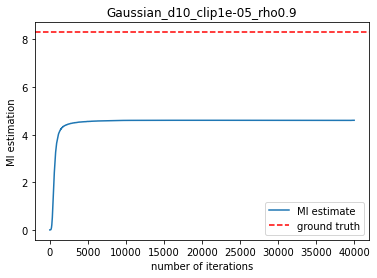

In [31]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('{}_d{}_clip{}_rho{}'.format(density, opt.d, opt.gamma, opt.rho))
plt.legend()
# plt.savefig('./results/DIEM/{}_d{}_clip{}_rho{}.pdf'.format(density, opt.d, opt.gamma, opt.rho))
# plt.savefig('./results/DIEM/NoClip{}_d{}_smooth{}_rho{}.pdf'.format(density, opt.d, opt.confidence, opt.rho))

In [33]:
torch.save(mi_copy, './mine.pth')